# Robot Arm
![ost logo](images/ost_logo.png) <br>
**Author:** Joshoua Bigler <br>
**Date:** 2025-01-04 <br>

## Abstract
The goal of this project is to develop a comprehensive simulation of a robotic arm using a physics
based machine learning (PBML) approach. The simulation aims to effectively model the physical be-
havior of the robotic arm, incorporating a variety of disturbing factors to create a realistic environment
for evaluating control algorithms and performance. To accomplish this, the analytical robotic arm is
modeled using a Lagrangian formulation. Trajectories derived from this formulation are then used to
train an ordinary differential equation network (ODE-Net) to replicate the dynamics of the robotic arm. 

## Description
This Jupyter Notebook is solely designed to provide an interactive guide for creating the robot arm. For detailed documentation on this project, please refer to [[2]](/docs/robot_arm.pdf). It is recommended to open the PDF alongside this notebook for a comprehensive understanding of the project. Note that the steps within the notebook are documented in a simplified manner.

## Declaration of Independence
"I hereby certify that I have written this thesis independently and have not used any
auxiliary materials other than those indicated. The passages of the work, which are
taken in the wording or the sense after other works (to it also Internet sources count),
were marked under indication of the source" <br>
<br>
Joshoua Bigler <br>
![Signature](images/signature.png) <br>
Date: 2025-01-04 <br>

## References
[1] Christoph Würsch, *Computational Physics I: Deterministisches Chaos bei gekoppelten nichlinearen DGL*, OST Ostschweizer Fachhochschule, 2024 <br>
[2] Joshoua Bigler, *Robot Arm*, OST Ostschweizer Fachhochschule, 2025, /docs/robot_arm.pdf <br>
[3] Matplotlib Animation, *The double pendulum problem*, https://matplotlib.org/stable/gallery/animation/double_pendulum.html <br>




In [1]:
import numpy as np
import torch
from IPython.display import HTML
from sympy import init_printing
from torchdiffeq import odeint
# local
from robot.robot_arm import NumericRobotArm, create_init_states, numeric_robot_arm, process_trajectories, SymbolicRobotArm, get_equation_of_motion
from robot.ode_net import OdeNet, get_device, Trajectory, create_data_batches, train_network, OdeNet2, OdeNet3
from robot.analysis import normalize, denormalize
from robot.visualize import animate_robot_arm, plot_simulated_trajectory, plot_training_loss, plot_evaluation_loss, plot_outer_points, plot_trajectory, plot_energies
from robot.utils import load_txt_file, create_trajectory, load_trajectories, save_txt_file
# setup
%matplotlib inline
init_printing(pretty_print=True, use_unicode=False)

## State Space Representation with the Euler-Lagrange Equation
In order to get the equation of motion a Lagrangian approach is taken.

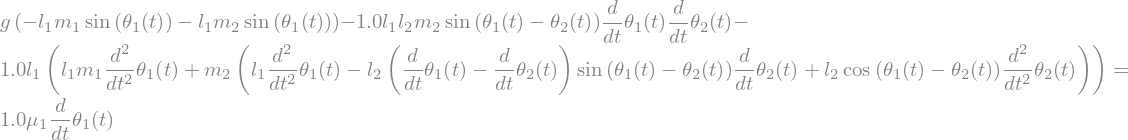

In [2]:
symbolic_robot_arm = SymbolicRobotArm()
euler_lagrange = symbolic_robot_arm.euler_lagrange_dissipation_eq
euler_lagrange[0]

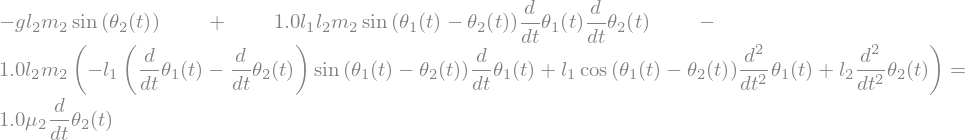

In [3]:
symbolic_robot_arm = SymbolicRobotArm()
euler_lagrange = symbolic_robot_arm.euler_lagrange_dissipation_eq
euler_lagrange[1]

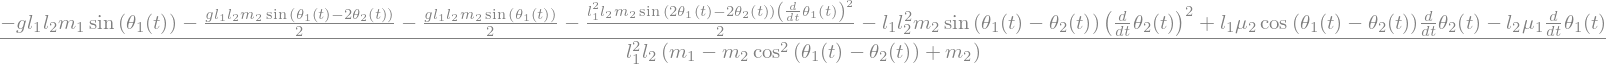

In [4]:
symbolic_equation = symbolic_robot_arm.solve_euler_lagrange(euler_lagrange)
eq_theta1, eq_theta2 = get_equation_of_motion(system=symbolic_robot_arm, equation=symbolic_equation)
eq_theta1

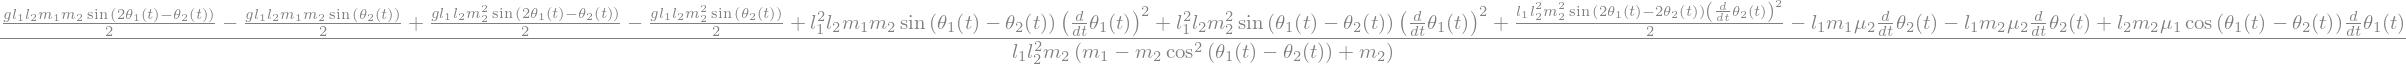

In [5]:
eq_theta2

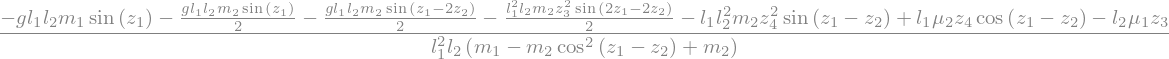

In [6]:
eq_theta1 = symbolic_robot_arm.first_order_transform(equation=eq_theta1)
eq_theta1

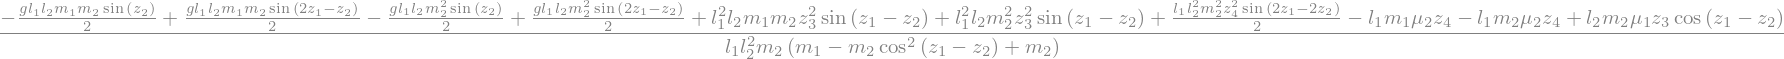

In [7]:
eq_theta2 = symbolic_robot_arm.first_order_transform(equation=eq_theta2)
eq_theta2

## Numeric Robot Arm
In order to create the analytical trajectories derived from the euler lagrangian equation of the robot arm, the inital conditions and the time span needs to be defined. The versions can be set accoring to [2], (pp, 11 - 12). Since to create a bunch of trajectories can takes some time, the trajectories are created in advanced with the python module [create_trajectories.py](create_trajectories.py) and can be loaded from the path `./data/trajectories/trajectories_v<trajectory_version>.npz`

In [8]:
version = '35'
trajectory_version = '41'
init_state='20'
t_stop = 15
dt=t_stop / 100
time_points = np.arange(0, t_stop, dt)
robot_arm = NumericRobotArm(m1=10.0, m2=10.0, l1=1, l2=1, mu1=1, mu2=1)
z0 = create_init_states(version=init_state)

Init state: [0.01560186 0.01559945 0.         0.        ]


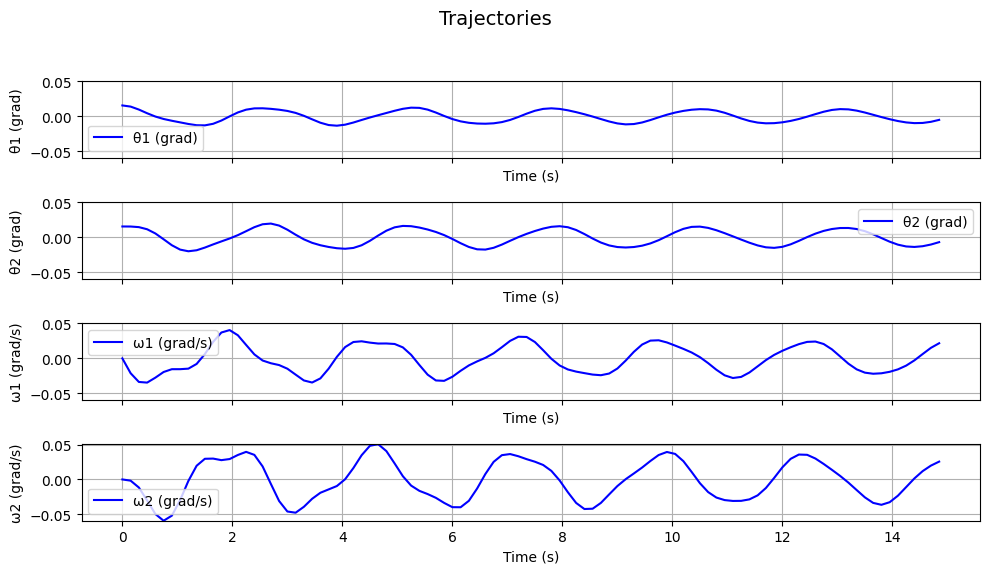

In [9]:
%matplotlib inline
analytic_trajectories = load_trajectories(file_name=f'trajectories_v{trajectory_version}')
print(f'Init state: {z0[2]}')
plot_simulated_trajectory(data=analytic_trajectories[2], time_points=time_points)

In [10]:
%matplotlib notebook
x1, y1, x2, y2 = robot_arm.convert_to_coordinates(y=analytic_trajectories[200])
ani =  animate_robot_arm(x1=x1, y1=y1, x2=x2, y2=y2, dt=dt, total_time=t_stop)
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

In order to train the ODE-Net in a more opimized manner, the trajecories needs to be normalized.

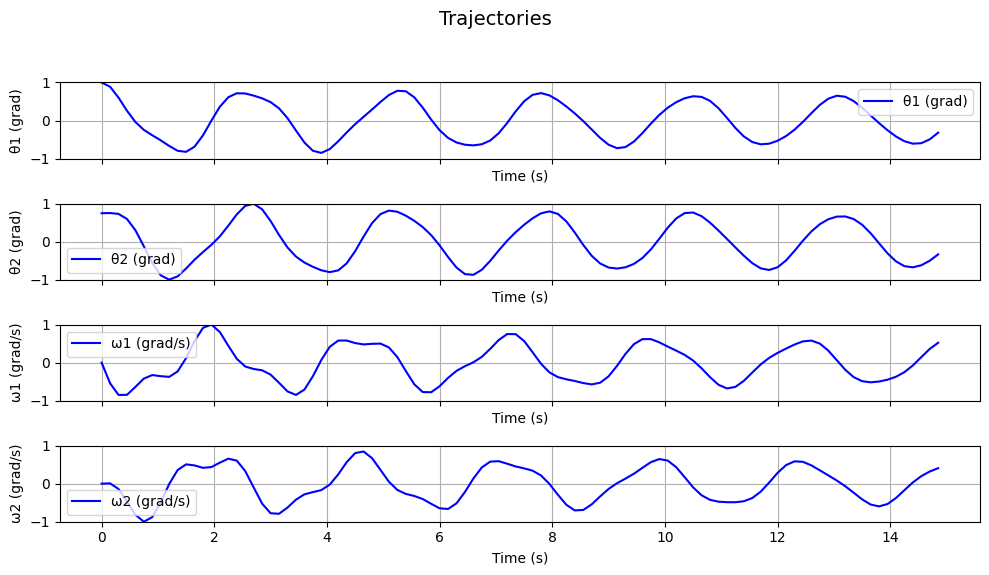

In [11]:
%matplotlib inline
data = load_trajectories(file_name=f'trajectories_v{trajectory_version}')
data_norm = normalize(data)
plot_simulated_trajectory(data=data_norm[1000], time_points=time_points)

# ODE-Net
The ODE-Net is trained with the normalized analytical trajectories. Since the training of the model takes some time, the model is trained in advanced with the python module [train_ode_net.py](train_ode_net.py) and can be loaded from the path `./data/models/model_adjoint_v<model_version>.pth`. The model version can be set according to [2], (pp, 11-12).

## Training and Evaluation Losses

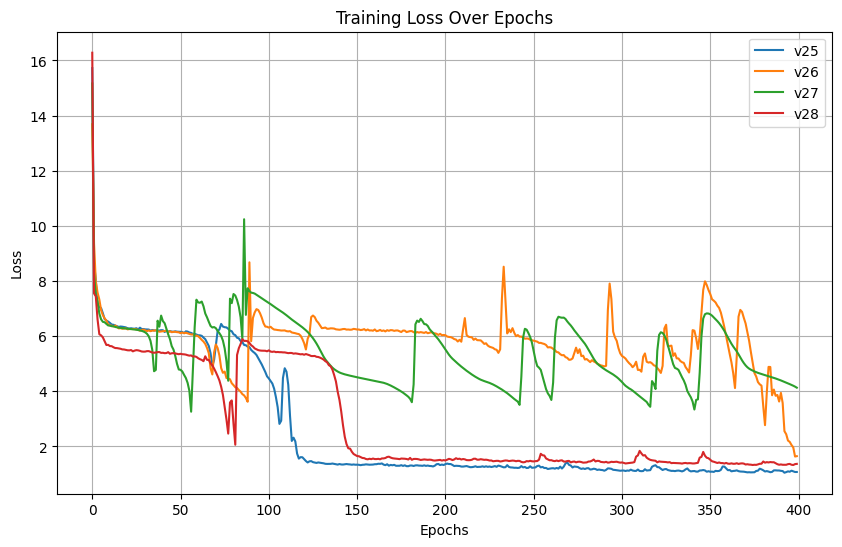

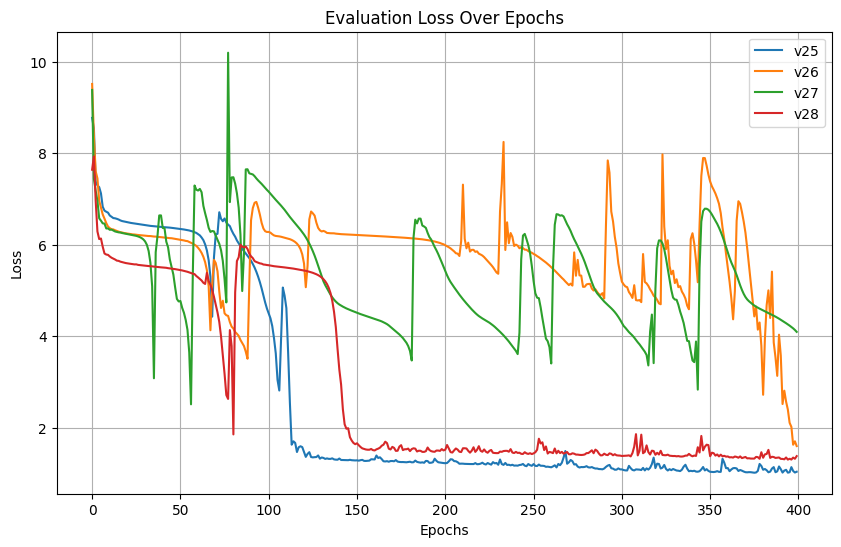

In [12]:
%matplotlib inline
training_losses = []
training_losses.append(load_txt_file(file_name=f'model_adjoint_training_losses_v25'))
training_losses.append(load_txt_file(file_name=f'model_adjoint_training_losses_v26'))
training_losses.append(load_txt_file(file_name=f'model_adjoint_training_losses_v27'))
training_losses.append(load_txt_file(file_name=f'model_adjoint_training_losses_v28'))
plot_training_loss(training_losses, epochs=len(training_losses[0]), labels=['v25', 'v26', 'v27', 'v28'])
eval_losses = []
eval_losses.append(load_txt_file(file_name=f'model_adjoint_eval_losses_v25'))
eval_losses.append(load_txt_file(file_name=f'model_adjoint_eval_losses_v26'))
eval_losses.append(load_txt_file(file_name=f'model_adjoint_eval_losses_v27'))
eval_losses.append(load_txt_file(file_name=f'model_adjoint_eval_losses_v28'))
plot_evaluation_loss(eval_losses, epochs=len(eval_losses[0]), labels=['v25', 'v26', 'v27', 'v28'])

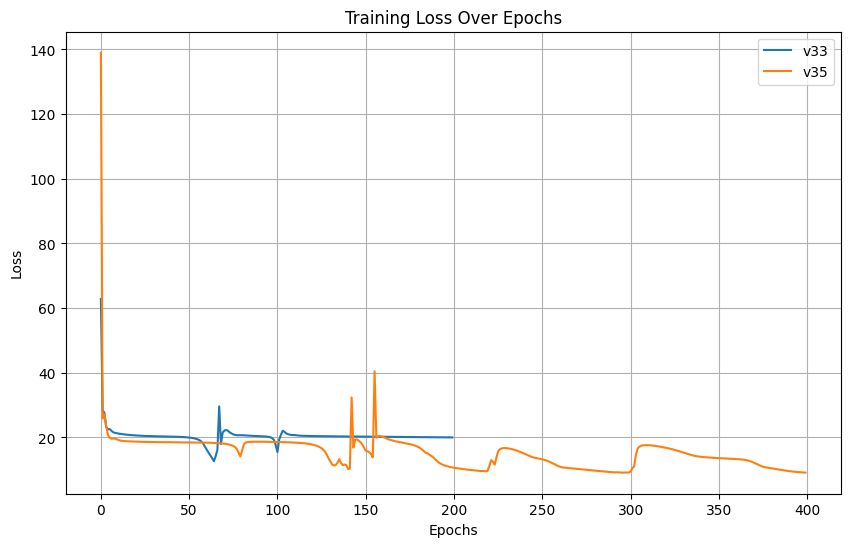

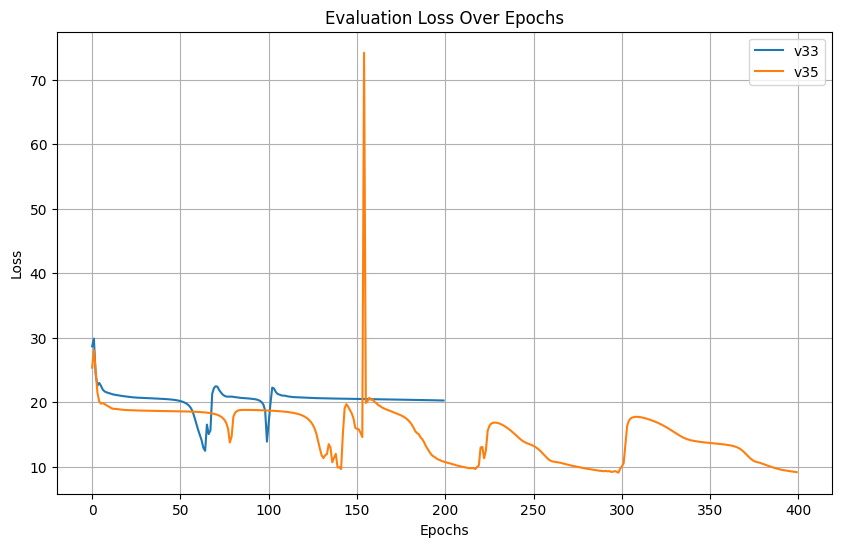

In [13]:
%matplotlib inline
training_losses = []
training_losses.append(load_txt_file(file_name=f'model_adjoint_training_losses_v33'))
training_losses.append(load_txt_file(file_name=f'model_adjoint_training_losses_v35'))
plot_training_loss(training_losses, epochs=len(training_losses[1]), labels=['v33', 'v35'])
eval_losses = []
eval_losses.append(load_txt_file(file_name=f'model_adjoint_eval_losses_v33'))
eval_losses.append(load_txt_file(file_name=f'model_adjoint_eval_losses_v35'))
plot_evaluation_loss(eval_losses, epochs=len(eval_losses[1]), labels=['v33', 'v35'])

## Trajectories

C:\Users\josho\AppData\Local\Temp\ipykernel_38664\4172672431.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'data/models/model_adjoin

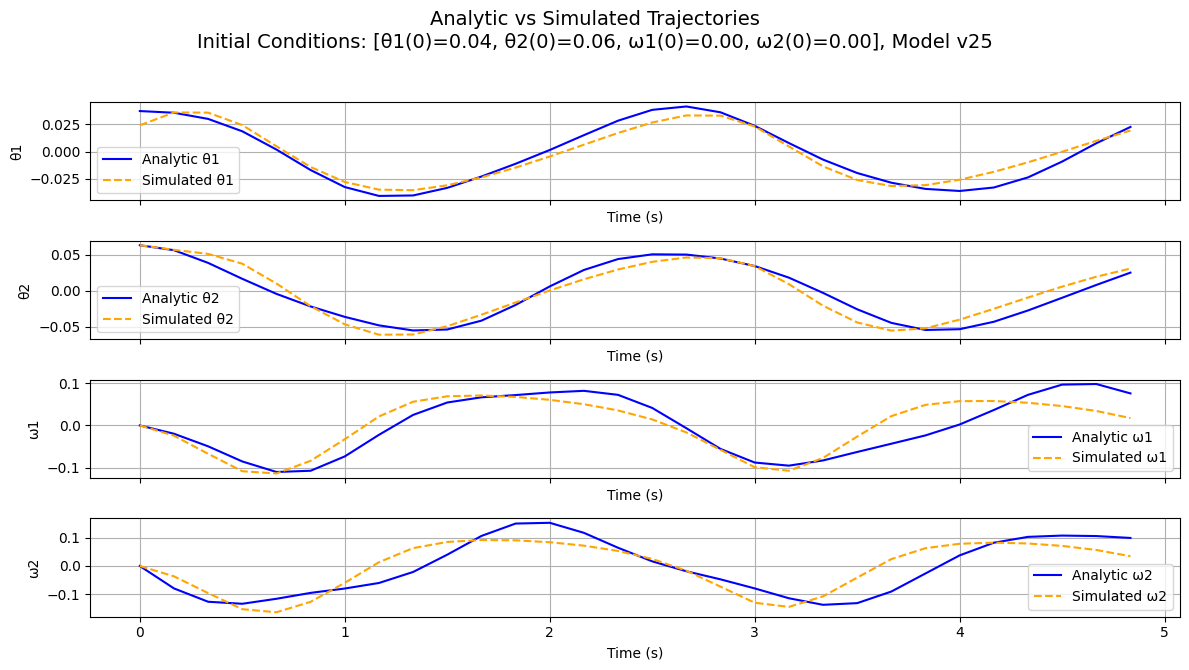

In [14]:
%matplotlib inline
version = '25'
trajectory_version = '20'
init_state='20'
t_stop = 5
dt=t_stop / 30
time_points = np.arange(0, t_stop, dt)
model = OdeNet2(features=4, latent_dim=128)
trajectory_number = 80

z0 = create_init_states(version=init_state)
z0_norm = normalize(z0)
model.load_state_dict(torch.load(f'data/models/model_adjoint_v{version}.pth'))
original_trajectories = load_trajectories(file_name=f'trajectories_v{trajectory_version}')
simulated_trajectory = create_trajectory(model=model, z0=z0_norm[trajectory_number], time_points=time_points, integrator=odeint)
simulated_trajectory = denormalize(simulated_trajectory, original_trajectories[trajectory_number])
plot_trajectory(y_analytic=original_trajectories[trajectory_number], y_simulated=simulated_trajectory, time_points=time_points, version=version)

C:\Users\josho\AppData\Local\Temp\ipykernel_38664\972926110.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'data/models/model_adjoint

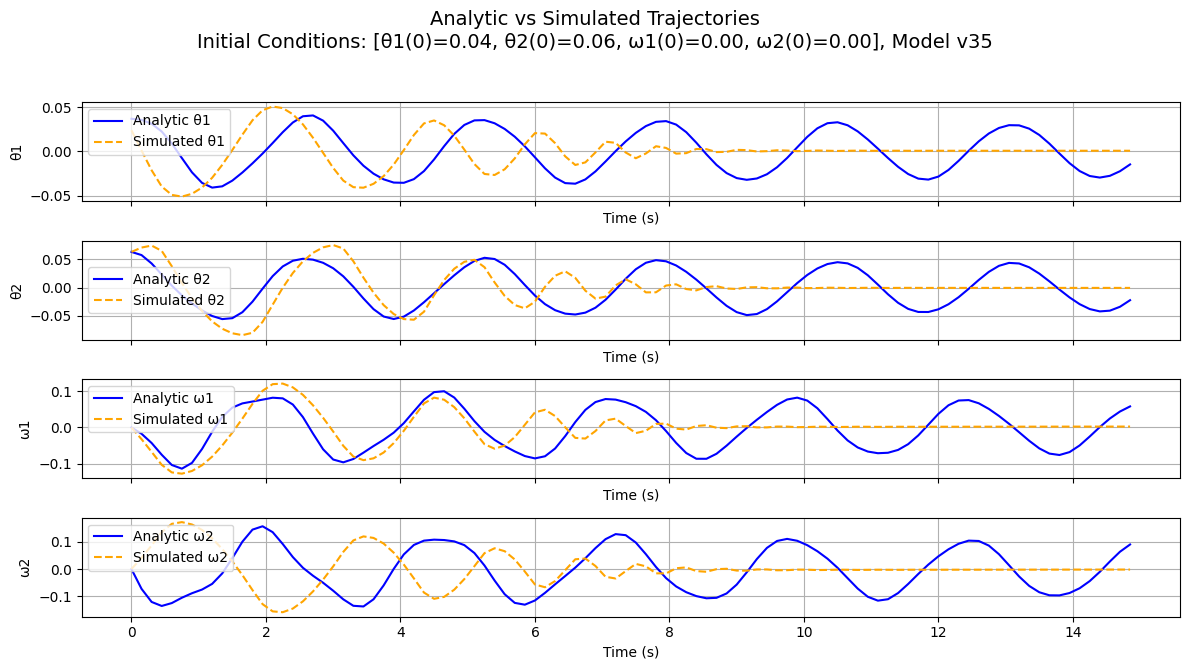

In [15]:
%matplotlib inline
version = '35'
init_state='20'
trajectory_version = '41'
t_stop = 15
dt=t_stop / 100
time_points = np.arange(0, t_stop, dt)
model = OdeNet3(features=4, latent_dim=128)
trajectory_number = 80

z0 = create_init_states(version=init_state)
z0_norm = normalize(z0)
model.load_state_dict(torch.load(f'data/models/model_adjoint_v{version}.pth'))
original_trajectories = load_trajectories(file_name=f'trajectories_v{trajectory_version}')
simulated_trajectory = create_trajectory(model=model, z0=z0_norm[trajectory_number], time_points=time_points, integrator=odeint)
simulated_trajectory = denormalize(simulated_trajectory, original_trajectories[trajectory_number])
plot_trajectory(y_analytic=original_trajectories[trajectory_number], y_simulated=simulated_trajectory, time_points=time_points, version=version)

# Energy Conservation

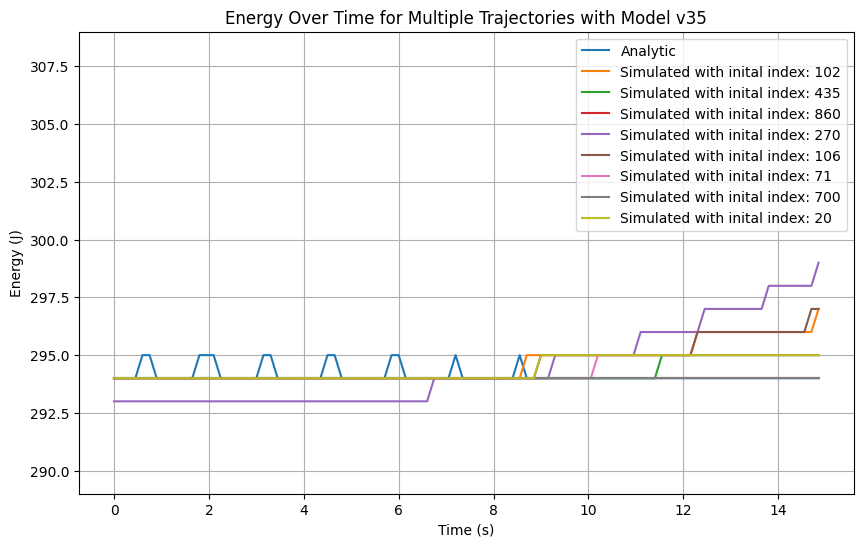

In [16]:
%matplotlib inline
version = '35'
init_state='20'
trajectory_version = '41'
t_stop = 15
dt=t_stop / 100
time_points = np.arange(0, t_stop, dt)
model = OdeNet3(features=4, latent_dim=128)
trajectory_number = 80

z0 = create_init_states(version=init_state)
z0_norm = normalize(z0)
original_trajectories=load_trajectories(file_name=f'trajectories_v{trajectory_version}')
energy_values = []
labels = ['Analytic']
energy_values.append(robot_arm.energy_over_time(trajectories=original_trajectories[trajectory_number], time_points=time_points))
np.random.seed(42)
for _ in range(8):
  index = np.random.randint(0, len(z0_norm))
  sim_trajectory = create_trajectory(model=model, z0=z0_norm[index], time_points=time_points, integrator=odeint)
  sim_trajectory = denormalize(sim_trajectory, original_trajectories[index])
  labels.append(f'Simulated with inital index: {index}')
  energy_values.append(robot_arm.energy_over_time(trajectories=sim_trajectory, time_points=time_points))
plot_energies(energies=energy_values, time_points=time_points, labels=labels, version=version)

In [17]:
%matplotlib notebook
version = '35'
init_state='20'
trajectory_version = '41'
t_stop = 15
dt=t_stop / 100
time_points = np.arange(0, t_stop, dt)
model = OdeNet3(features=4, latent_dim=128)
trajectory_number = 80

z0 = create_init_states(version=init_state)
z0_norm = normalize(z0)
model.load_state_dict(torch.load(f'data/models/model_adjoint_v{version}.pth'))
simulated_trajectory = create_trajectory(model=model, z0=z0_norm[trajectory_number], time_points=time_points, integrator=odeint)
simulated_trajectory = denormalize(simulated_trajectory, original_trajectories[trajectory_number])
x1, y1, x2, y2 = robot_arm.convert_to_coordinates(y=simulated_trajectory)
ani =  animate_robot_arm(x1=x1, y1=y1, x2=x2, y2=y2, dt=dt, total_time=t_stop)
HTML(ani.to_html5_video())

C:\Users\josho\AppData\Local\Temp\ipykernel_38664\893415343.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'data/models/model_adjoint

<IPython.core.display.Javascript object>